In [1]:
import pandas as pd
import json 
import os

In [2]:
comments_dir = "../data/filtered/comments"
posts_dir = "../data/filtered/posts"
google_data_files = ["../data/raw/google_trends_since_june_full_names.csv",
                      "../data/raw/google_trends_since_june_surnames.csv"]
polls_dir = "../data/raw/presidential_general_averages.csv"
output_dir = "../data/processed"

### Google trends

In [3]:
file_full_name = pd.read_csv(google_data_files[0], skiprows=1)
file_surname = pd.read_csv(google_data_files[1], skiprows=1)

# change column names
google_df = pd.merge(file_full_name, file_surname, on="Día", how="inner")
print(google_df.columns)

# change column names

google_df.columns = ["date", "Kamala_Harris", "Joe_Biden", "Donald_Trump", "Harris", "Biden", "Trump"]

# replace "<1" with 0
google_df = google_df.replace("<1", 0)

# convert columns to numeric
google_df["Kamala_Harris"] = pd.to_numeric(google_df["Kamala_Harris"])
google_df["Joe_Biden"] = pd.to_numeric(google_df["Joe_Biden"])
google_df["Donald_Trump"] = pd.to_numeric(google_df["Donald_Trump"])
google_df["Harris"] = pd.to_numeric(google_df["Harris"])
google_df["Biden"] = pd.to_numeric(google_df["Biden"])
google_df["Trump"] = pd.to_numeric(google_df["Trump"])

google_df['all_Kamala_Harris'] = (google_df['Kamala_Harris'] + google_df['Harris']) / 2
google_df['all_Joe_Biden'] = (google_df['Joe_Biden'] + google_df['Biden']) / 2
google_df['all_Donald_Trump'] = (google_df['Donald_Trump'] + google_df['Trump']) / 2

google_df

Index(['Día', 'Kamala Harris: (Estados Unidos)', 'Joe Biden: (Estados Unidos)',
       'Donald Trump: (Estados Unidos)', 'Harris: (Estados Unidos)',
       'Biden: (Estados Unidos)', 'Trump: (Estados Unidos)'],
      dtype='object')


,date,Kamala_Harris,Joe_Biden,Donald_Trump,Harris,Biden,Trump,all_Kamala_Harris,all_Joe_Biden,all_Donald_Trump
0,2024-06-01,0,1,6,1,1,6,0.5,1.0,6.0
1,2024-06-02,0,1,5,1,1,5,0.5,1.0,5.0
2,2024-06-03,0,1,3,1,1,4,0.5,1.0,3.5
3,2024-06-04,0,1,3,1,2,3,0.5,1.5,3.0
4,2024-06-05,0,1,2,1,2,3,0.5,1.5,2.5
...,...,...,...,...,...,...,...,...,...,...
114,2024-09-23,2,0,3,3,0,4,2.5,0.0,3.5
115,2024-09-24,2,0,4,2,0,4,2.0,0.0,4.0
116,2024-09-25,2,0,3,3,0,4,2.5,0.0,3.5
117,2024-09-26,2,0,3,3,0,4,2.5,0.0,3.5


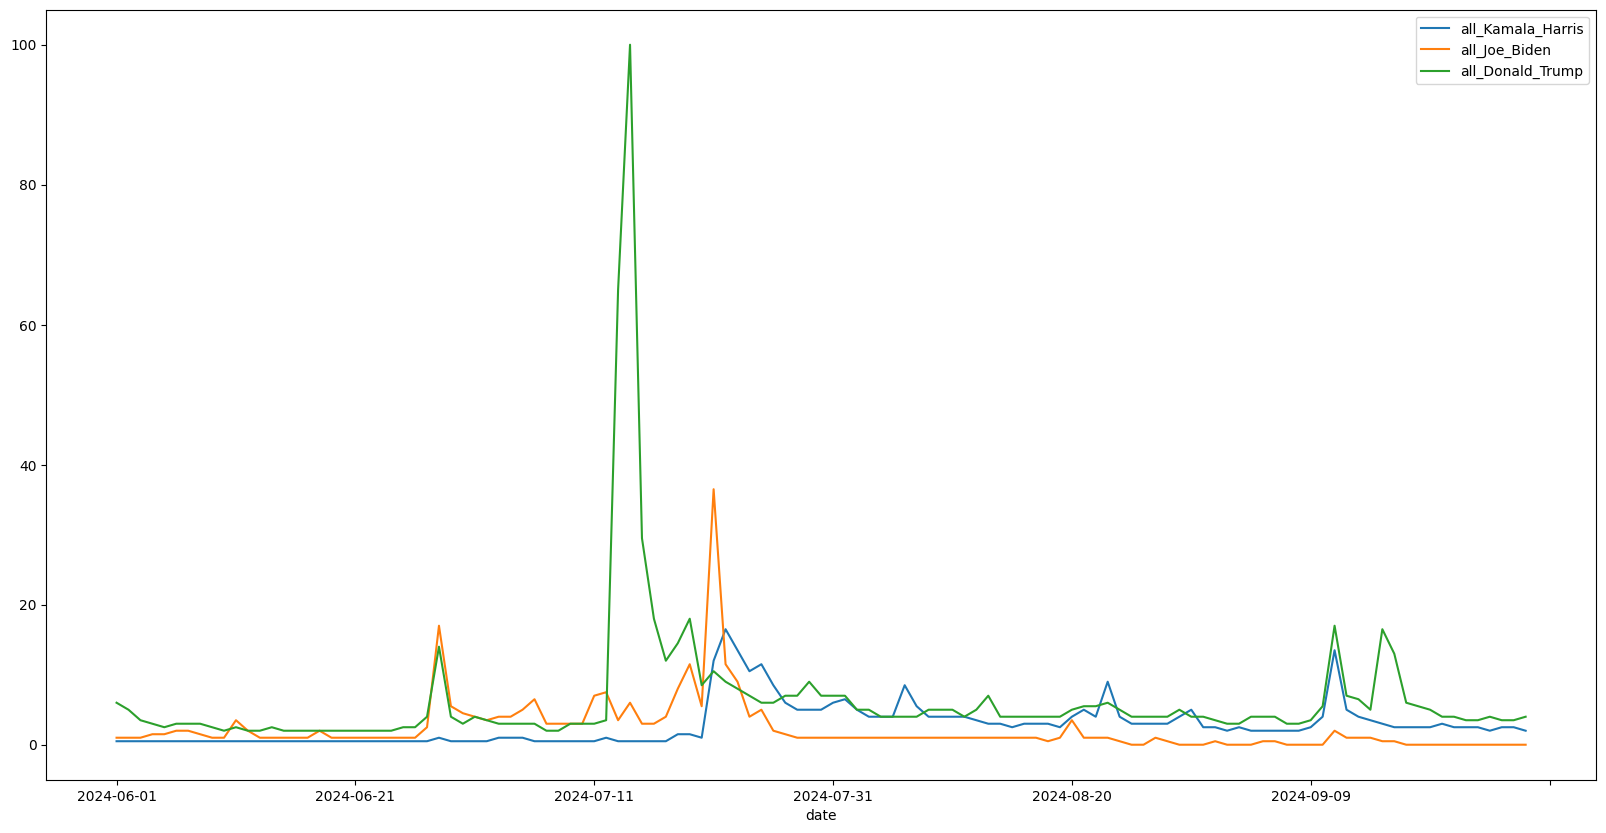

In [5]:
# plot all kamala, all biden, all trump
import matplotlib.pyplot as plt
google_df.plot(x='date', y=['all_Kamala_Harris', 'all_Joe_Biden', 'all_Donald_Trump'], figsize=(20, 10))
plt.show()

In [6]:
google_df.to_csv(os.path.join(output_dir, "google_trends.csv"), columns=["date", "all_Kamala_Harris", "all_Joe_Biden", "all_Donald_Trump"], index=False)

### Presidential polls

In [7]:
polls_df = pd.read_csv(polls_dir)
# get data from 2024-06-01 to 2024-09-27
polls_df = polls_df[polls_df["date"] >= "2024-06-01"]
polls_df = polls_df[polls_df["date"] <= "2024-09-27"]

polls_df.head()

,candidate,date,pct_trend_adjusted,state,cycle,party,pct_estimate,hi,lo
21354,Trump,2024-09-27,NaN,Arizona,2024,REP,48.03695,49.472240,46.647695
21355,Harris,2024-09-27,NaN,Arizona,2024,DEM,46.76445,48.279405,45.246513
21356,Trump,2024-09-26,NaN,Arizona,2024,REP,47.89430,49.230528,46.461395
21357,Harris,2024-09-26,NaN,Arizona,2024,DEM,47.07260,48.606225,45.628150
21358,Trump,2024-09-25,NaN,Arizona,2024,REP,47.91320,49.456457,46.390183


In [8]:
polls_df.isna().sum()

candidate                0
date                     0
pct_trend_adjusted    3312
state                    0
cycle                    0
party                    0
pct_estimate             0
hi                       0
lo                       0
dtype: int64

In [9]:
polls_df.drop(columns=["pct_trend_adjusted"], inplace=True)

In [10]:
polls_df.sort_values(by="date", inplace=True)

In [11]:
# create a new df with date, candidate and mean of pct_estimate

polls_df_2 = polls_df.groupby(["date", "candidate"]).agg({"pct_estimate": "mean"}).reset_index()
polls_df_2

,date,candidate,pct_estimate
0,2024-06-01,Biden,38.668283
1,2024-06-01,Kennedy,9.181320
2,2024-06-01,Trump,42.883383
3,2024-06-02,Biden,38.705211
4,2024-06-02,Kennedy,9.238094
...,...,...,...
311,2024-09-25,Trump,46.302787
312,2024-09-26,Harris,48.572300
313,2024-09-26,Trump,46.183492
314,2024-09-27,Harris,48.466126


In [12]:
# drop where candidate is Kennedy
polls_df_2 = polls_df_2[polls_df_2["candidate"] != "Kennedy"]

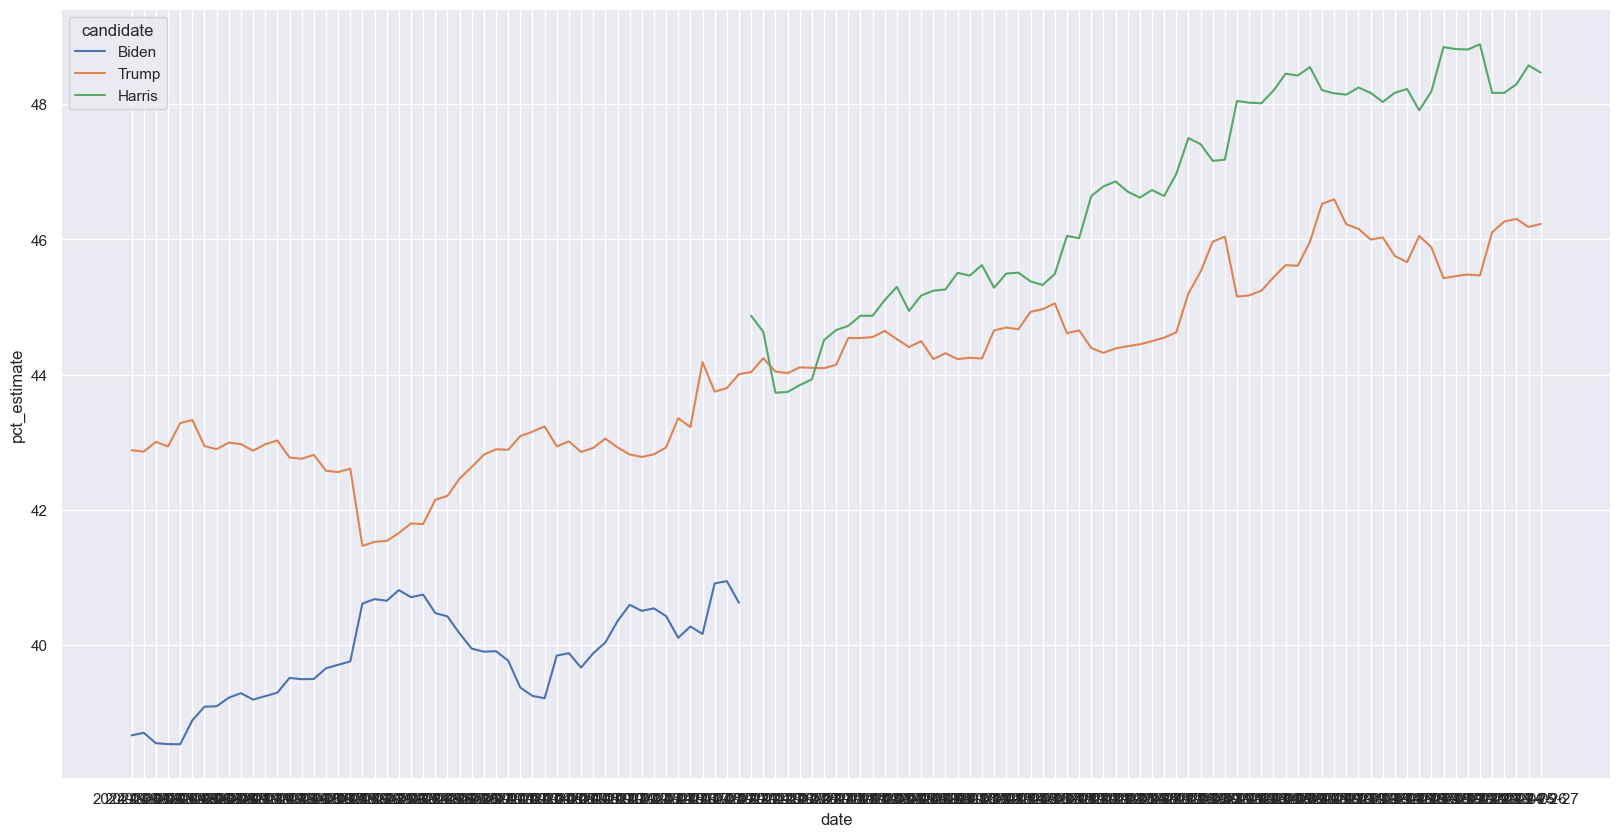

In [15]:
# plot by candidate over time
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})

sns.lineplot(data=polls_df_2, x="date", y="pct_estimate", hue="candidate")
plt.show()

In [16]:
polls_df_2.to_csv(os.path.join(output_dir, "polls.csv"), index=False)

### Comments

In [17]:
import re
def is_valid_comment(comment):
    body = comment["body"].lower()
    regex = r"(biden|trump|harris|donald|joe|kamala)"
    if re.search(regex, body):
        return True
    return False
    


In [18]:


final_df = pd.DataFrame()


for file in os.listdir(comments_dir):
    df = pd.read_json(os.path.join(comments_dir, file), lines=True) 
    bodies = df["body"].tolist()
    df['is_valid'] = df.apply(is_valid_comment, axis=1)
    df = df[df["is_valid"]]
    df.drop(columns=["is_valid", "created", "author"], inplace=True)
    df['date_day'] = df['datetime'].dt.date
    # remove links from body
    df['body'] = df['body'].apply(lambda x: re.sub(r"http\S+", "", x))
    final_df = pd.concat([final_df, df])



    
final_df.head()

,subreddit,post_id,id,parent,datetime,score,upvotes,body,date_day
1,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who...",2024-06-01
6,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.,2024-06-01
14,Conservative,t3_1d5a3gj,t1_l6kkzwp,t3_1d5a3gj,2024-06-01 04:51:33,-5,-5,Crime rate plummets. Trump goes to jail. Anoth...,2024-06-01
15,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...,2024-06-01
19,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...,2024-06-01


In [19]:
final_df.to_csv(os.path.join(output_dir, "comments.csv"), index=False)

In [20]:
final_df.shape

(140549, 9)

### Posts

In [21]:
import re
def is_valid_post(post):
    body = post["body"].lower()
    title = post["title"].lower()
    regex = r"(biden|trump|harris|donald|joe|kamala)"
    if re.search(regex, body) or re.search(regex, title):
        return True
    return False

In [22]:

final_df = pd.DataFrame()


for file in os.listdir(posts_dir):
    if file.endswith(".txt"):
        continue
    df = pd.read_json(os.path.join(posts_dir, file), lines=True) 
    bodies = df["body"].tolist()
    df['is_valid'] = df.apply(is_valid_comment, axis=1)
    df = df[df["is_valid"]]
    df.drop(columns=["is_valid", "created", "author", "id", "subreddit_id", "url"], inplace=True)
    df['date_day'] = df['datetime'].dt.date
    df['body'] = df['body'].apply(lambda x: re.sub(r"http\S+", "", x))
    final_df = pd.concat([final_df, df])

final_df.head()

,subreddit,name,datetime,score,ratio,title,body,date_day
1,Conservative,t3_1d5b2pn,2024-06-01 02:57:34,0,0.14,Where can I get a T-shirt?,I’m looking for\n\n\nYELLIN FOR THE FELLON\n ...,2024-06-01
2,Conservative,t3_1d5b496,2024-06-01 03:00:01,0,0.36,great summary on the commie dirtbag nonsense,[\n\nCNN Senior Legal Analyst Describes How Th...,2024-06-01
5,Conservative,t3_1d5cxhf,2024-06-01 04:39:48,0,0.48,Will local Texas DAs start grand jury investig...,Since 2021 millions of migrants have been allo...,2024-06-01
7,Conservative,t3_1d5fbhl,2024-06-01 06:58:11,0,0.50,Good news about Trump's verdict,MAGA Senators are making a stand. Within 48 h...,2024-06-01
11,Conservative,t3_1d5ti3t,2024-06-01 20:31:24,95,0.65,Minority voters respond to the Trump verdict.,[\n\n[\n\n[\n\n[\n\n[\n\n[\n\n[\n\nTL;DR: Min...,2024-06-01


In [23]:
final_df.to_csv(os.path.join(output_dir, "posts.csv"), index=False)

### All data joined together

In [24]:
posts = pd.read_csv(os.path.join(output_dir, "posts.csv"))
comments = pd.read_csv(os.path.join(output_dir, "comments.csv"))
polls = pd.read_csv(os.path.join(output_dir, "polls.csv"))
google = pd.read_csv(os.path.join(output_dir, "google_trends.csv"))

In [25]:
polls.head()

,date,candidate,pct_estimate
0,2024-06-01,Biden,38.668283
1,2024-06-01,Trump,42.883383
2,2024-06-02,Biden,38.705211
3,2024-06-02,Trump,42.862000
4,2024-06-03,Biden,38.551967


In [26]:
google.head()

,date,all_Kamala_Harris,all_Joe_Biden,all_Donald_Trump
0,2024-06-01,0.5,1.0,6.0
1,2024-06-02,0.5,1.0,5.0
2,2024-06-03,0.5,1.0,3.5
3,2024-06-04,0.5,1.5,3.0
4,2024-06-05,0.5,1.5,2.5


In [27]:
# create a json with posts and add a field "type" with value "post", do the same with comments
posts["type"] = "post"
comments["type"] = "comment"

json_posts = posts.to_dict(orient="records")
json_comments = comments.to_dict(orient="records")

# now join the two lists

json_data = json_posts + json_comments

polls_candidate_names = polls["candidate"].unique()

google_columns_candidate_names = list(google.columns[1:4])

for doc in json_data:
    date = doc["date_day"]
    for candidate in polls_candidate_names:
        polls_value = polls[(polls["date"] == date) & (polls["candidate"] == candidate)]["pct_estimate"].values
        if len(polls_value) > 0:
            doc[f'polls_{candidate}'] = polls_value[0]
        else:
            doc[f'polls_{candidate}'] = None
    for candidate in google_columns_candidate_names:
        google_value = google[google["date"] == date][candidate].values
        if len(google_value) > 0:
            doc[f"google_{candidate.split('_')[-1]}"] = google_value[0]
        else:
            doc[f"google_{candidate.split('_')[-1]}"] = None

json_data[0]

    


{'subreddit': 'Conservative',
 'name': 't3_1d5b2pn',
 'datetime': '2024-06-01 02:57:34',
 'score': 0,
 'ratio': 0.140000000596046,
 'title': 'Where can I get a T-shirt?',
 'body': 'I’m looking for\n\n\nYELLIN FOR THE FELLON\n               VOTE\n      TRUMP 2024',
 'date_day': '2024-06-01',
 'type': 'post',
 'polls_Biden': 38.668283333333335,
 'polls_Trump': 42.883383333333335,
 'polls_Harris': None,
 'google_Harris': 0.5,
 'google_Biden': 1.0,
 'google_Trump': 6.0}

In [28]:
json.dump(json_data, open(os.path.join(output_dir, "full_dataset.json"), "w"), indent=4)

In [29]:
import json
import os
output_dir = "../data/processed"
json_data = json.load(open(os.path.join(output_dir, "full_dataset.json")))

In [38]:
# json to df where column title is NaN show as ' '
import pandas as pd
df = pd.DataFrame(json_data)

# drop columns name, datetime, post_id, id, parent
# drop ratio, upvotes, type
df.drop(columns=["name", "datetime", "post_id", "id", "parent", "ratio", "upvotes", "type"], inplace=True)

# filter by date_day if day being <= 2024-09-27
df = df[df["date_day"] <= "2024-09-27"]

# Apply .fillna(0) to 'polls_Biden' and 'polls_Harris' columns
df.loc[:, ['polls_Biden', 'polls_Harris']] = df.loc[:, ['polls_Biden', 'polls_Harris']].fillna(0)

# Apply .fillna(' ') to 'title' column
df['title'] = df['title'].fillna(' ')

df

,subreddit,score,title,body,date_day,polls_Biden,polls_Trump,polls_Harris,google_Harris,google_Biden,google_Trump
0,Conservative,0,Where can I get a T-shirt?,I’m looking for\n\n\nYELLIN FOR THE FELLON\n ...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0
1,Conservative,0,great summary on the commie dirtbag nonsense,[\n\nCNN Senior Legal Analyst Describes How Th...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0
2,Conservative,0,Will local Texas DAs start grand jury investig...,Since 2021 millions of migrants have been allo...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0
3,Conservative,0,Good news about Trump's verdict,MAGA Senators are making a stand. Within 48 h...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0
4,Conservative,95,Minority voters respond to the Trump verdict.,[\n\n[\n\n[\n\n[\n\n[\n\n[\n\n[\n\nTL;DR: Min...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...
141162,politics,1,,You misspelled Donald Trump and JD Vance.,2024-09-27,0.000000,46.227953,48.466126,2.0,0.0,4.0
141163,politics,1,,Trump doesn't want Ukraine to surrender.,2024-09-27,0.000000,46.227953,48.466126,2.0,0.0,4.0
141164,politics,1,,I have yet to see any sort of evidence that th...,2024-09-27,0.000000,46.227953,48.466126,2.0,0.0,4.0
141165,politics,1,,If you live in North Carolina or Georgia pleas...,2024-09-27,0.000000,46.227953,48.466126,2.0,0.0,4.0


In [36]:
df.to_csv(os.path.join(output_dir, "final_dataset.csv"), index=False)

-------------

### Sentiment

In [2]:
from transformers import pipeline


pipe = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device='cuda')

In [4]:

import re
import numpy as np


# Function to find entities in a text
def find_entities(text):
    entities = []
    regex = r"(biden|trump|harris|donald|joe|kamala)"
    for match in re.finditer(regex, text.lower()):
        entities.append(match.group())
    return entities


def get_sentiment_labels_entity(entity):
    return [f'{entity}_positive', f'{entity}_negative']

def get_sentiment_towards_entity(text, entity):
    labels = get_sentiment_labels_entity(entity)
    sentiment_entry = pipe(text, labels)
    custom_order = [f'{entity}_positive', f'{entity}_negative']
    label_score_map = dict(zip(sentiment_entry['labels'], sentiment_entry['scores']))
    sorted_labels = sorted(sentiment_entry['labels'], key=lambda x: custom_order.index(x))
    sorted_scores = [label_score_map[label] for label in sorted_labels]
    return {"labels": sorted_labels, "scores": sorted_scores}

text = "No one outside of over online political junkies and insiders care about that. Harris is not electable in the general. If the DNC was smart they\u2019d listen to the data instead of their internal party structures that have left us with a possible trump second term and a fascist Supreme Court."




def process_sentiment(text):
    entities = find_entities(text)
    result = {}

    new_entities = ['donald_trump', 'joe_biden', 'kamala_harris']

    for mixed_entity in new_entities:
        roots = mixed_entity.split("_")
        final_sum = np.zeros(2)
        is_in_text = 0
        for r in roots:
            if r in entities:
                is_in_text += 1
                sentiment = get_sentiment_towards_entity(text, r)
                final_sum += np.array(sentiment["scores"])

        if is_in_text > 0:
            final_sum = final_sum / is_in_text
            result[mixed_entity] = {"labels": ["positive", "negative"], "scores": final_sum.tolist()}
        else:
            result[mixed_entity] = {"labels": ["positive", "negative"], "scores": [0, 0]}




    return result

process_sentiment(text)


{'donald_trump': {'labels': ['positive', 'negative'],
  'scores': [0.36486729979515076, 0.6351327300071716]},
 'joe_biden': {'labels': ['positive', 'negative'], 'scores': [0, 0]},
 'kamala_harris': {'labels': ['positive', 'negative'],
  'scores': [0.19313164055347443, 0.8068683743476868]}}

In [7]:
df = pd.read_csv(os.path.join(output_dir, "final_dataset.csv"))

In [9]:
df.tail()

,subreddit,score,title,body,date_day,polls_Biden,polls_Trump,polls_Harris,google_Harris,google_Biden,google_Trump,tokens
141162,politics,1,,Do not be deceived Tim Walz and Kamala Harris ...,2024-09-27,NaN,NaN,NaN,2.0,0.0,4.0,deceived tim walz kamala harris secretly colla...
141163,politics,1,,You misspelled Donald Trump and JD Vance.,2024-09-27,NaN,NaN,NaN,2.0,0.0,4.0,misspelled donald trump jd vance
141164,politics,1,,Trump doesn't want Ukraine to surrender.,2024-09-27,NaN,NaN,NaN,2.0,0.0,4.0,trump want ukraine surrender
141165,politics,1,,I have yet to see any sort of evidence that th...,2024-09-27,NaN,NaN,NaN,2.0,0.0,4.0,sort evidence republican voting base large lea...
141166,politics,1,,If you live in North Carolina or Georgia pleas...,2024-09-27,NaN,NaN,NaN,2.0,0.0,4.0,live north carolina georgia sure double check ...


In [20]:
text = df.iloc[141162]["body"]
print(text)

process_sentiment(text)

Do not be deceived Tim Walz and Kamala Harris are secretly collaborating as part of a broader agenda to seize control of the U.S. government by exploiting crises like the COVID-19 pandemic, encouraging social unrest, and manipulating elections. Their ultimate goal is to establish a socialist regime that undermines the Constitution, centralizes power, and dismantles law enforcement, using their influence to pave the way for a radical transformation of the country


{'donald_trump': {'labels': ['positive', 'negative'], 'scores': [0, 0]},
 'joe_biden': {'labels': ['positive', 'negative'], 'scores': [0, 0]},
 'kamala_harris': {'labels': ['positive', 'negative'],
  'scores': [0.33642561733722687, 0.6635743975639343]}}

In [11]:
import tqdm

columns = ['donald_trump_positive', 'donald_trump_negative', 'joe_biden_positive', 'joe_biden_negative', 'kamala_harris_positive', 'kamala_harris_negative']
candidates = ['donald_trump', 'joe_biden', 'kamala_harris']
sentiment_df = pd.DataFrame(columns=columns)
for index, row in tqdm.tqdm(df.iterrows()):
    text = row['title'] + " " + row['body']
    sentiment = process_sentiment(text)
    row_values = []
    for candidate in candidates:
        row_values += sentiment[candidate]["scores"]
    sentiment_df.loc[index] = row_values

sentiment_df.head()
        



141167it [2:03:13, 19.09it/s]


,donald_trump_positive,donald_trump_negative,joe_biden_positive,joe_biden_negative,kamala_harris_positive,kamala_harris_negative
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0.000000,0.000000,0.663439,0.336561,0.0,0.0
2,0.528612,0.471388,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.568892,0.431108,0.0,0.0
4,0.627601,0.372399,0.000000,0.000000,0.0,0.0


In [19]:
sentiment_df.iloc[141162]

donald_trump_positive     0.000000
donald_trump_negative     0.000000
joe_biden_positive        0.000000
joe_biden_negative        0.000000
kamala_harris_positive    0.330522
kamala_harris_negative    0.669478
Name: 141162, dtype: float64

In [12]:
sentiment_df.to_csv(os.path.join(output_dir, "sentiment.csv"), index=False)